In [57]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Background formulation

$$ \min \sum_{t=1}^{\text{prediction horizon}} u_{heat,t} + u_{cool,t} + discomfort_{heat,t} + discomfort_{cool,t}$$

$$ \text{where: } $$
$$T_{in,t+1} = \alpha_1T_{in,t} + \alpha_2T_{in,t-1} + \beta_1 u_{heat,t} + \beta_2 u_{heat,t-1} +\beta_3 u_{cool,t} + \beta_4 u_{cool,t-1} \\ + \theta_1 T_{out,t} + \theta_2 T_{out,t-1} + \theta_3 q_{solar,t} + \theta_4 q_{solar,t-1} + constant$$

$$ u_{heat,t},  u_{cool,t} \in \{0,1\}$$

$$ u_{heat,t} + u_{cool,t} \leq 1 $$

$$discomfort_{heat,t} = \max(T_{heat,t}- T_{in,t},0) $$

$$discomfort_{cool,t} = \max(T_{in,t} - T_{cool,t},0) $$

# Some initial setup

In [58]:
# stole these from an actual model
model_params = {'site_air_temp_lb0': -0.07705090827283811,
 'site_air_temp_lb1': 0.0868922241344876,
 'site_direct_solar_lb0': -0.0001144392615515244,
 'site_direct_solar_lb1': 0.0001809371597119025,
 'sensible_heating_bool_lb0': 0.668022493564159,
 'sensible_heating_bool_lb1': -0.1212789391296738,
 'sensible_cooling_bool_lb0': 0.0,
 'sensible_cooling_bool_lb1': 0.0,
 'zone_mean_air_temp_lb0': 0.9534713323209267,
 'zone_mean_air_temp_lb1': 0.014742719358824985,
 'intercept': 0.40977951}

In [59]:
ar_order = 2 
history_lb = ar_order -1 # this gets used a fair bit 
horizon = 72 # prediction horizion

In [60]:
# real tout for 6 hours
tout = [0.5, -0.09999999999999988, -0.6999999999999998, -1.3, -1.9, -2.5, -3.1, -3.7, -4.299999999999999, -4.9, -5.499999999999999, -6.1, -5.958333333333332, -5.816666666666666, -5.674999999999999, -5.533333333333334, -5.3916666666666675, -5.25, -5.1083333333333325, -4.966666666666667, -4.825, -4.683333333333334, -4.541666666666667, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, -4.4, -4.541666666666666, -4.683333333333334, -4.825, -4.966666666666667, -5.1083333333333325, -5.25, -5.391666666666668, -5.533333333333332, -5.674999999999999, -5.816666666666666, -5.958333333333332, -6.1, -6.008333333333333, -5.916666666666666, -5.8249999999999975, -5.7333333333333325, -5.6416666666666675, -5.55, -5.458333333333332, -5.366666666666667, -5.275, -5.183333333333334, -5.091666666666667, -5.0, -5.091666666666667, -5.183333333333334, -5.275, -5.366666666666667, -5.458333333333332, -5.55, -5.641666666666668, -5.7333333333333325, -5.8249999999999975, -5.916666666666666, -6.008333333333333, -6.1, -6.1916666666666655]

# no solar for now
solar = [0 for x in range(len(tout))]

# some made up setpoints with transitions
heat_stp = [19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 16.67, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0]

cool_stp = [23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89, 23.89]

Text(0, 0.5, 'Temp [oC]')

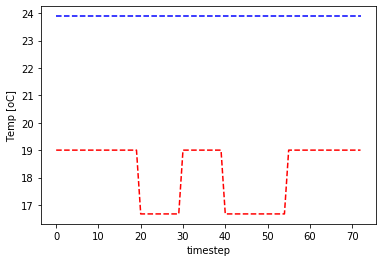

In [61]:
plt.plot(heat_stp,'--r')
plt.plot(cool_stp, '--b')
plt.xlabel('timestep')
plt.ylabel('Temp [oC]')

In [62]:
# some made up intial conditions in the form [t, t+1]
temp_init = [22.0, 22.8]
heat_init = [0,0]
cool_init = [0,0]
# this means our first temperature prediction is for t+2

In [63]:
def useful_debugging_script_i_found(model):
    ### VERY USEFUL DEBUG TOOL!!!
    status = model.status
    if status == GRB.UNBOUNDED:
        print('The model cannot be solved because it is unbounded')

    if status == GRB.OPTIMAL:
        print('The optimal objective is %g' % m.objVal)

    if status != GRB.INF_OR_UNBD and status != GRB.INFEASIBLE:
        print('Optimization was stopped with status %d' % status)

    # do IIS
    print('The model is infeasible; computing IIS')
    removed = []

    # Loop until we reduce to a model that can be solved
    while True:

        model.computeIIS()
        print('\nThe following constraint cannot be satisfied:')
        for c in model.getConstrs():
            if c.IISConstr:
                print('%s' % c.constrName)
                # Remove a single constraint from the model
                removed.append(str(c.constrName))
                model.remove(c)
                break
        print('')

        model.optimize()
        status = model.status

        if status == GRB.UNBOUNDED:
            print('The model cannot be solved because it is unbounded')

        if status == GRB.OPTIMAL:
            break
        if status != GRB.INF_OR_UNBD and status != GRB.INFEASIBLE:
            print('Optimization was stopped with status %d' % status)


    print('\nThe following constraints were removed to get a feasible LP:')
    print(removed)

In [64]:
# what is the natural decay curve?
t_natural_decay = np.zeros(horizon+history_lb)
heat_state = np.zeros(horizon+history_lb)
cool_state = np.zeros(horizon+history_lb)

t_natural_decay[:2] = temp_init
heat_state[:2] = heat_init
heat_state[:2] = cool_init
    
for t in range(history_lb, horizon):                      
    t_natural_decay[t+1] = model_params['zone_mean_air_temp_lb0']*t_natural_decay[t] + model_params['zone_mean_air_temp_lb1']*t_natural_decay[t-1] \
        + model_params['sensible_heating_bool_lb0']*heat_state[t] + model_params['sensible_heating_bool_lb1']*heat_state[t-1] + model_params['sensible_cooling_bool_lb0']*cool_state[t] \
        + model_params['sensible_cooling_bool_lb1']*cool_state[t-1] + model_params['site_air_temp_lb0']*tout[t] + model_params['site_air_temp_lb1']*tout[t-1] \
        + model_params['site_direct_solar_lb0']*solar[t] + model_params['site_direct_solar_lb1']*solar[t-1] + model_params['intercept']

Text(0.5, 0, 'timestep')

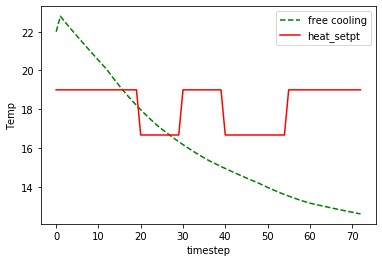

In [65]:
plt.plot(t_natural_decay,'--g', label="free cooling")

plt.plot(heat_stp,label='heat_setpt',color='red')
plt.legend()
plt.ylabel('Temp')
plt.xlabel('timestep')

# First pass. If the only cost is runtime what does it do?

In [66]:
m = gp.Model("control-p1")

# initalize the model variables
t_in = [m.addVar( name=f"Tin_{t}") for t in range(horizon+history_lb)]

heat_state = [m.addVar(vtype=GRB.BINARY, name=f"HS_{t}") for t in range(horizon+history_lb)]
cool_state = [m.addVar(vtype=GRB.BINARY, name=f"CS_{t}") for t in range(horizon+history_lb)]

# set initial conditions
for t in range(0, ar_order):
    m.addConstr(t_in[t] == temp_init[t], name=f"init_temp_{t}")
    m.addConstr(heat_state[t] == heat_init[t], name=f"init_heat_{t}")
    m.addConstr(cool_state[t] == cool_init[t], name=f"init_cool_{t}")
m.update()

# the actual prediction contraints
for t in range(history_lb, horizon):
    # state evolution
    m.addConstr(t_in[t+1] == model_params['zone_mean_air_temp_lb0']*t_in[t] + model_params['zone_mean_air_temp_lb1']*t_in[t-1]
              + model_params['sensible_heating_bool_lb0']*heat_state[t] + model_params['sensible_heating_bool_lb1']*heat_state[t-1] 
              + model_params['sensible_cooling_bool_lb0']*cool_state[t] + model_params['sensible_cooling_bool_lb1']*cool_state[t-1]
              + model_params['site_air_temp_lb0']*tout[t] + model_params['site_air_temp_lb1']*tout[t-1]
              + model_params['site_direct_solar_lb0']*solar[t] + model_params['site_direct_solar_lb1']*solar[t-1]
              + model_params['intercept'], name=f"SysEv_{t}")

    # system exclusive
    m.addConstr((heat_state[t] + cool_state[t]) <= 1, name=f"SysEx_{t}")

m.update()  


# set the objective.
obj = gp.quicksum([1.0*heat_state[t] + 1.0*cool_state[t] for t in range(ar_order,horizon)])

m.Params.timeLimit = 100.0
m.setObjective(obj,GRB.MINIMIZE)
m.optimize() 

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 148 rows, 219 columns and 503 nonzeros
Model fingerprint: 0x094caa87
Variable types: 73 continuous, 146 integer (146 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+01]
Found heuristic solution: objective 0.0000000

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 6 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


Text(0.5, 0, 'timestep')

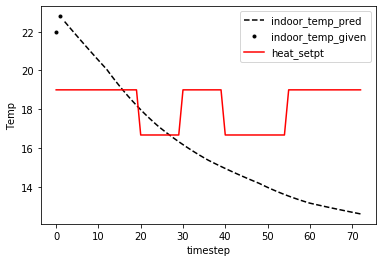

In [67]:
plt.plot(np.arange(ar_order, len(t_in)), [x.x for x in t_in[ar_order:]],'--k', label="indoor_temp_pred")
plt.plot([x.x for x in t_in[:ar_order]],'.k',label="indoor_temp_given")
plt.plot(heat_stp,label='heat_setpt',color='red')
plt.legend()
plt.ylabel('Temp')
plt.xlabel('timestep')

### Notes:
This seems to make sense. It would decide to not run at all. Cost nothing and just coast in temperature.

# Seconds pass. What happens if i give it hard setpoints?

In [68]:
m = gp.Model("control-p2")

# initalize the model variables
t_in = [m.addVar( name=f"Tin_{t}") for t in range(horizon+history_lb)]

heat_state = [m.addVar(vtype=GRB.BINARY, name=f"HS_{t}") for t in range(horizon+history_lb)]
cool_state = [m.addVar(vtype=GRB.BINARY, name=f"CS_{t}") for t in range(horizon+history_lb)]

# set initial conditions
for t in range(0, ar_order):
    m.addConstr(t_in[t] == temp_init[t], name=f"init_temp_{t}")
    m.addConstr(heat_state[t] == heat_init[t], name=f"init_heat_{t}")
    m.addConstr(cool_state[t] == cool_init[t], name=f"init_cool_{t}")
m.update()

# the actual prediction contraints
for t in range(history_lb, horizon):
    # state evolution
    m.addConstr(t_in[t+1] == model_params['zone_mean_air_temp_lb0']*t_in[t] + model_params['zone_mean_air_temp_lb1']*t_in[t-1]
              + model_params['sensible_heating_bool_lb0']*heat_state[t] + model_params['sensible_heating_bool_lb1']*heat_state[t-1] 
              + model_params['sensible_cooling_bool_lb0']*cool_state[t] + model_params['sensible_cooling_bool_lb1']*cool_state[t-1]
              + model_params['site_air_temp_lb0']*tout[t] + model_params['site_air_temp_lb1']*tout[t-1]
              + model_params['site_direct_solar_lb0']*solar[t] + model_params['site_direct_solar_lb1']*solar[t-1]
              + model_params['intercept'], name=f"SysEv_{t}")

    # system exclusive
    m.addConstr((heat_state[t] + cool_state[t]) <= 1, name=f"SysEx_{t}")

m.update()  

for t in range(history_lb, horizon+1):    
    # hard setpoints (for testing)
    m.addConstr(t_in[t] >= heat_stp[t], name=f"AbsH_{t}")
    m.addConstr(t_in[t] <= cool_stp[t], name=f"AbsC_{t}")
m.update()  

# set the objective. Currently weights are still just 1.0
obj = gp.quicksum([1.0*heat_state[t] + 1.0*cool_state[t] for t in range(ar_order,horizon+1)])
m.update()

m.Params.timeLimit = 100.0
m.setObjective(obj,GRB.MINIMIZE)
m.optimize() 

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 292 rows, 219 columns and 647 nonzeros
Model fingerprint: 0x81d3b229
Variable types: 73 continuous, 146 integer (146 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+01]
Presolve removed 225 rows and 82 columns
Presolve time: 0.00s
Presolved: 67 rows, 137 columns, 336 nonzeros
Variable types: 67 continuous, 70 integer (70 binary)
Found heuristic solution: objective 25.0000000

Root relaxation: objective 2.359061e+01, 91 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   23.72463    0   42   25.00000   23.72463  5.10%     -    0s
     0     0     cutoff    0        25.

Text(0.5, 0, 'timestep')

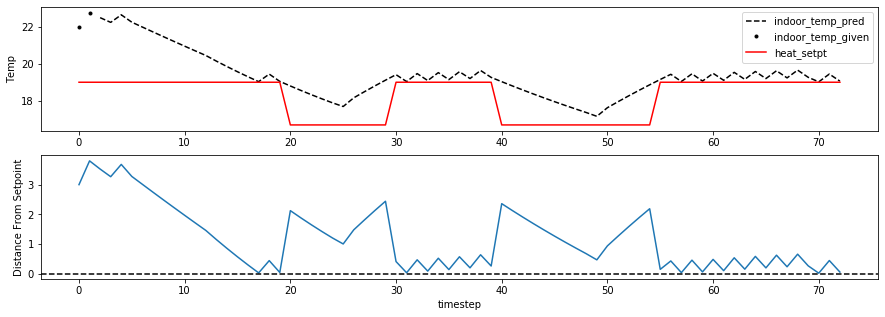

In [69]:
fig, axs = plt.subplots(2,figsize=(15,5))

axs[0].plot(np.arange(ar_order, len(t_in)), [x.x for x in t_in[ar_order:]],'--k', label="indoor_temp_pred")
axs[0].plot([x.x for x in t_in[:ar_order]],'.k',label="indoor_temp_given")
axs[0].plot(heat_stp,label='heat_setpt',color='red')
axs[0].legend()
axs[0].set_ylabel('Temp')


error = [a_i.x - b_i for a_i, b_i in zip(t_in, heat_stp)]
axs[1].plot(error)
axs[1].axhline(0,color='k',linestyle='dashed')
axs[1].set_ylabel('Distance From Setpoint')
axs[1].set_xlabel('timestep')

### Notes:
Again this seems to make sense. It never touchs the setpoints would seem to only run the heating when it has to. 

# Third pass. Add discomfort penatly instead of hard constraints.

Hard setpoints aren't what i want. would rather the controller simply was penalized for being uncomfortable 

In [70]:
m = gp.Model("control-p3")

# initalize the model variables
t_in = [m.addVar( name=f"Tin_{t}") for t in range(horizon+history_lb)]
heat_state = [m.addVar(vtype=GRB.BINARY, name=f"HS_{t}") for t in range(horizon+history_lb)]
cool_state = [m.addVar(vtype=GRB.BINARY, name=f"CS_{t}") for t in range(horizon+history_lb)]

heat_dev_term = [m.addVar(vtype=GRB.CONTINUOUS, name=f"dev_{t}") for t in range(horizon+history_lb)]
heat_discomfort_ = [m.addVar(vtype=GRB.CONTINUOUS, name=f"HD_{t}") for t in range(horizon+history_lb)]

# set initial conditions
for t in range(0, ar_order):
    m.addConstr(t_in[t] == temp_init[t], name=f"init_temp_{t}")
    m.addConstr(heat_state[t] == heat_init[t], name=f"init_heat_{t}")
    m.addConstr(cool_state[t] == cool_init[t], name=f"init_cool_{t}")
m.update()

# the actual prediction contraints
for t in range(history_lb, horizon):
    # state evolution
    m.addConstr(t_in[t+1] == model_params['zone_mean_air_temp_lb0']*t_in[t] + model_params['zone_mean_air_temp_lb1']*t_in[t-1]
              + model_params['sensible_heating_bool_lb0']*heat_state[t] + model_params['sensible_heating_bool_lb1']*heat_state[t-1] 
              + model_params['sensible_cooling_bool_lb0']*cool_state[t] + model_params['sensible_cooling_bool_lb1']*cool_state[t-1]
              + model_params['site_air_temp_lb0']*tout[t] + model_params['site_air_temp_lb1']*tout[t-1]
              + model_params['site_direct_solar_lb0']*solar[t] + model_params['site_direct_solar_lb1']*solar[t-1]
              + model_params['intercept'], name=f"SysEv_{t}")
    
m.update()  

for t in range(history_lb, horizon+1):
    # system exclusive
    m.addConstr((heat_state[t] + cool_state[t]) <= 1, name=f"SysEx_{t}")
    #max function can't handle the operation inside it.
    m.addConstr(heat_dev_term[t] == heat_stp[t] - t_in[t], name=f"temp_heat_dev_{t}") 
m.update()  

# just incase this works..
for t in range(history_lb, horizon+1):
    m.addConstr(heat_discomfort_[t] == gp.max_(heat_dev_term[t],0), name=f"heat_discomfort_{t}")
m.update()

# set the objective. Currently weights are still just 1.0
# Note still not even included.
obj = gp.quicksum([1.0*heat_state[t] + 1.0*cool_state[t] + heat_discomfort_[t] for t in range(ar_order,horizon+1)])
m.update()

m.Params.timeLimit = 100.0
m.setObjective(obj,GRB.MINIMIZE)
m.optimize() 

Changed value of parameter timeLimit to 100.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 221 rows, 365 columns and 649 nonzeros
Model fingerprint: 0xa148827c
Model has 72 general constraints
Variable types: 219 continuous, 146 integer (146 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+01]
Presolve removed 72 rows and 75 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 6 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


In [71]:
useful_debugging_script_i_found(m)

The model is infeasible; computing IIS

Computing Irreducible Inconsistent Subsystem (IIS)...

      Constraints           Bounds       Runtime
     Min       Max       Min      Max
------------------------------------------------
        0      293         0      219         0s
        2        2         1        1         0s

IIS computed: 2 constraints, 1 bounds
IIS runtime: 0.01 seconds

The following constraint cannot be satisfied:
init_temp_1

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 220 rows, 365 columns and 648 nonzeros
Model fingerprint: 0x3b51934f
Model has 72 general constraints
Variable types: 219 continuous, 146 integer (146 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+01]
Presolve removed 151 rows and 227 columns
Presolve time: 0.00s
Presolved: 69 rows, 138 columns, 341 nonzeros
Variable types: 69 continuous, 69 integer

### Notes:
Hmm so even with the inclusion of discomfort in the costs, it became infeasible. 

When i remove the discomfort from the objective it still is infeasible. 

Also based on the relaxing analysis, the second intial temp value is what is causing the pain. That is..odd..

Text(0.5, 0, 'timestep')

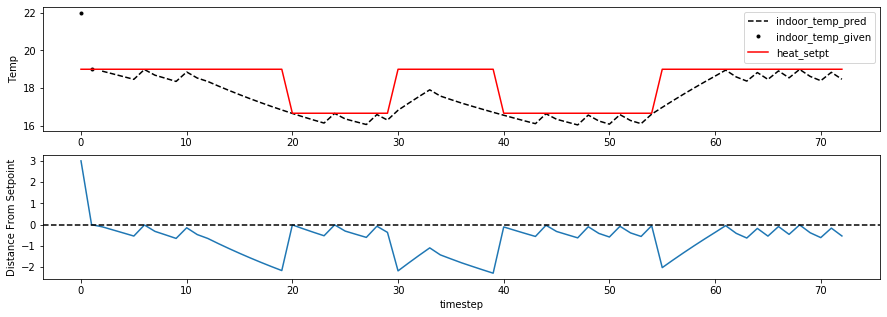

In [72]:
# out of curiousity what did the model decide to do by relaxing that most recent inital temperature value?

fig, axs = plt.subplots(2,figsize=(15,5))

axs[0].plot(np.arange(ar_order, len(t_in)), [x.x for x in t_in[ar_order:]],'--k', label="indoor_temp_pred")
axs[0].plot([x.x for x in t_in[:ar_order]],'.k',label="indoor_temp_given")
axs[0].plot(heat_stp,label='heat_setpt',color='red')
axs[0].legend()
axs[0].set_ylabel('Temp')


error = [a_i.x - b_i for a_i, b_i in zip(t_in, heat_stp)]
axs[1].plot(error)
axs[1].axhline(0,color='k',linestyle='dashed')
axs[1].set_ylabel('Distance From Setpoint')
axs[1].set_xlabel('timestep')